In [1]:
import sys

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import time

sys.path.append('../utils')
import data_paths
from traffic_counts import TrafficCounts
from hbefa_hot_emissions import HbefaHotEmissions

# Import data

In [2]:
# import speed and volume data from traffic counting stations
visum_links = gpd.read_file(data_paths.VISUM_FOLDER_PATH + 'visum_links_v2.gpkg')

# raw speed and counting data
cnt_lhm = pd.read_parquet(data_paths.MST_COUNTING_PATH + 'preprocessed_lhm_counting_data.parquet')

# only detectors that are assigned to a road link in the visum model
cnt_lhm = cnt_lhm[cnt_lhm['road_link_id'].isin(visum_links['road_link_id'].unique())] 
cnt_lhm_2019 = cnt_lhm[cnt_lhm['date'].between('2019-01-01','2019-12-31')] # reduce to 2019 data

# import traffic cycles
cycles = TrafficCounts()

# import hbefa emission factors
hbefa = HbefaHotEmissions()

Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_PC.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_LCV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_HGV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_Coach.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_MOT.XLS


# Prepare dataframe with detector information

In [3]:
# prepare dataframe with information about the detectors (from VISUM model)
_det = cnt_lhm_2019.set_index('detector_id')['road_link_id'].to_dict()
detector_information = pd.DataFrame.from_dict(_det, orient='index', columns=['road_link_id'])
detector_information['road_type'] = detector_information['road_link_id'].map(visum_links.set_index('road_link_id')['road_type'].to_dict())
detector_information['lanes'] = detector_information['road_link_id'].map(visum_links.set_index('road_link_id')['lanes'].to_dict())
detector_information['speed'] = detector_information['road_link_id'].map(visum_links.set_index('road_link_id')['speed'].to_dict())
detector_information['hour_capacity'] = detector_information['road_link_id'].map(visum_links.set_index('road_link_id')['hour_capacity'].to_dict())

# add ffs information from table S3-2 hbefa 2015
# normalbreiter Fahrstreifen -> f_FS = 1
# überbreiter Fahrstreifen -> f_FS = 0.7 (geringe Erschiesungsintensität), 0.8 (hohe Erschliesungsintensität)
# zwei markierte Fahrstreifen -> f_FSA = 0.5 (anbaufrei), 0.6 (geringe Erschiesungsintensität), 0.7 (hohe Erschliesungsintensität)
detector_information['f_FS'] = 1.
detector_information.loc[detector_information[detector_information['lanes']>=2].index, 'f_FS'] = 0.7 #insbesondere mittlerer Ring
detector_information.loc[detector_information[(detector_information['lanes']<2) &\
    (detector_information['hour_capacity']> 1000)].index, 'f_FS'] = 0.8 #Expertenschätzung: Straßen mit hoher Kapazität besitzen überbreite Fahrstreifen.

detector_information.head()

road_link_id               road_type  lanes  speed  hour_capacity  \
4010011       80645.0  TrunkRoad/Primary-City      3     50           5400   
4010012       80645.0  TrunkRoad/Primary-City      3     50           5400   
4010013       80645.0  TrunkRoad/Primary-City      3     50           5400   
4010014       80645.0  TrunkRoad/Primary-City      3     50           5400   
4010021       80645.0  TrunkRoad/Primary-City      3     50           5400   

         f_FS  
4010011   0.7  
4010012   0.7  
4010013   0.7  
4010014   0.7  
4010021   0.7

# Prepare Traffic Counting Dataset

In [4]:
#calculate total traffic volume and convert in personal car units
pkw_e_scaling_factors = hbefa.car_unit_factors

cnt_lhm_scaled = cnt_lhm_2019[(cnt_lhm_2019['metric']=='volume') &
                              (cnt_lhm_2019['vehicle_class']!='SUM')].copy() # take all traffic volume values besides the SUM
cnt_lhm_scaled['pcu_factor'] = cnt_lhm_scaled['vehicle_class'].map(pkw_e_scaling_factors)

hour_value_colums = [str(i) for i in list(range(1,25))] # hour value columns have string column names from 1 to 25

cnt_lhm_scaled[hour_value_colums] = cnt_lhm_scaled[hour_value_colums]\
    .mul(cnt_lhm_scaled['pcu_factor'], axis ='index')
    
volumes = cnt_lhm_scaled.groupby(['detector_id', 'date'])[hour_value_colums].sum(numeric_only = True)

# prepare speeds dataset
hour_value_colums.extend(['detector_id', 'date'])
speeds = cnt_lhm_2019[(cnt_lhm_2019['metric']=='speed') &
                      (cnt_lhm_2019['vehicle_class']=='PC')][hour_value_colums] # take speed values of PC as indicators

# combine speed and volume dataset
speeds = speeds.melt(id_vars=['date', 'detector_id'])
speeds = speeds.set_index(['detector_id', 'date', 'variable'])
speeds.rename(columns = {'value':'speed_true'}, inplace = True)

volumes = volumes.reset_index().melt(id_vars=['date', 'detector_id'])
volumes = volumes.set_index(['detector_id', 'date', 'variable'])
volumes.rename(columns = {'value':'volume_true'}, inplace = True)

combined_df = pd.concat([speeds, volumes], axis=1)

# reduce to useful data 
combined_df = combined_df[(combined_df['speed_true']>0) & (combined_df['volume_true']>0)]
combined_df.reset_index(inplace = True)

# combine date and time colume to a timestamp
combined_df['timestamp'] = combined_df.apply(lambda row: pd.Timestamp.combine(row['date'], time(int(row['variable'])-1)), axis =1)
combined_df.drop(['date', 'variable'], inplace =True, axis = 'columns')
combined_df.head()

detector_id  speed_true  volume_true  timestamp
0      4010011        48.0        43.00 2019-01-03
1      4010012        52.0       154.00 2019-01-03
2      4010013        52.0       287.75 2019-01-03
3      4010014        57.0        47.50 2019-01-03
4      4010021        54.0        78.75 2019-01-03

# Combine counting dataset and add LOS class

In [5]:
los_density_thresholds_50kmh = {7:'A',
                                14:'B',
                                23:'C',
                                34:'D',
                                45:'E'}

los_density_thresholds_70kmh = {6:'A',
                                12:'B',
                                20:'C',
                                30:'D',
                                40:'E'}

hbefa_road_abbreviations = hbefa.hbefa_road_abbreviations
hbefa_los_classes = hbefa.los_hbefa_mapping


def get_los_class_hbs(density, speed):
    if speed <=60: 
        for th, los in los_density_thresholds_50kmh.items(): 
            if th > density: 
                return los
        return 'F'
    elif speed > 60: 
        for th, los in los_density_thresholds_70kmh.items(): 
            if th > density: 
                return los
        return 'F'


def get_hbefa_los_class(los_class: str,
                        road_type:str,
                        hbefa_speed:int) -> str:
    praeamble  = "URB"
    los = f'{praeamble}/{hbefa_road_abbreviations[road_type]}/{str(hbefa_speed)}/{hbefa_los_classes[los_class]}'
    return los


def get_emission_factor(los_class): 
    ef_dict = hbefa.ef_dict['PC']['EFA_weighted']
    return ef_dict[(2019, los_class, '0%', 'CO2(rep)')]

combined_df_merged = combined_df.merge(detector_information, left_on='detector_id', right_index=True)
combined_df_merged['density'] = combined_df_merged['volume_true']/ combined_df_merged['speed_true']
combined_df_merged['density_scaled'] = combined_df_merged['density'] * combined_df_merged['f_FS']

combined_df_merged['LOS_hbs'] = combined_df_merged.apply(lambda row: get_los_class_hbs(row['density_scaled'],
                                                                                       row['speed']), axis = 1)

combined_df_merged['LOS_hbefa'] = combined_df_merged.apply(lambda row: get_hbefa_los_class(row['LOS_hbs'],
                                                                                           row['road_type'], 
                                                                                           row['speed']), axis = 1)

# add emission factor
combined_df_merged['ef_PC_co2(rep)'] = combined_df_merged['LOS_hbefa'].map(get_emission_factor)
combined_df_merged.head()

detector_id  speed_true  volume_true  timestamp  road_link_id  \
0        4010011        48.0         43.0 2019-01-03       80645.0   
96       4010011        50.0         60.0 2019-01-04       80645.0   
192      4010011        48.0         97.0 2019-01-05       80645.0   
289      4010011        44.0         76.0 2019-01-06       80645.0   
386      4010011        49.0         40.0 2019-01-07       80645.0   

                  road_type  lanes  speed  hour_capacity  f_FS   density  \
0    TrunkRoad/Primary-City      3     50           5400   0.7  0.895833   
96   TrunkRoad/Primary-City      3     50           5400   0.7  1.200000   
192  TrunkRoad/Primary-City      3     50           5400   0.7  2.020833   
289  TrunkRoad/Primary-City      3     50           5400   0.7  1.727273   
386  TrunkRoad/Primary-City      3     50           5400   0.7  0.816327   

     density_scaled LOS_hbs                   LOS_hbefa  ef_PC_co2(rep)  
0          0.627083       A  URB/Trunk-City/50/Freeflow      142.353775  
96         0.840000       A  URB/Trunk-City/50/Freeflow      142.353775  
192        1.414583       A  URB/Trunk-City/50/Freeflow      142.353775  
289        1.209091       A  URB/Trunk-City/50/Freeflow      142.353775  
386        0.571429       A  URB/Trunk-City/50/Freeflow      142.353775

# Plotting

Text(0.5, 0, 'Traffic volume [pcu/h]')

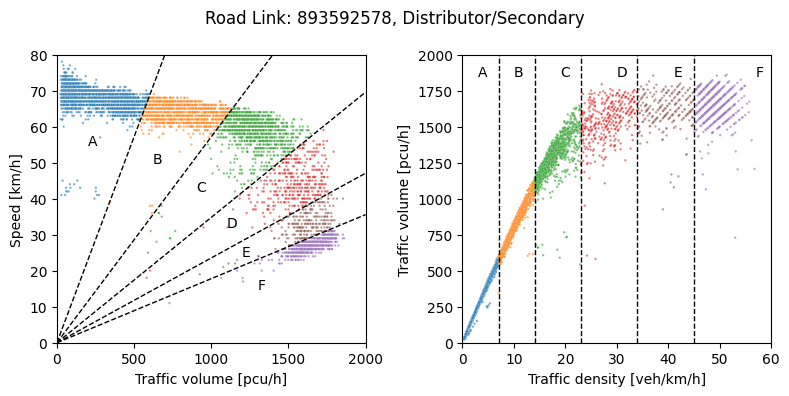

In [22]:
# plot data from individual road link

plot_df = combined_df_merged.set_index('road_link_id')#, 'detector_id', 'timestamp'])
road_link = 893592578
    
df = plot_df.loc[road_link]
road_type = df['road_type'].iloc[0]
total_traffic_volume = df.groupby('timestamp')['volume_true'].sum()
detector_ids = df['detector_id'].unique()

fig, ax = plt.subplots(1,2, figsize =(8,4), tight_layout=True)

plt.suptitle(f'Road Link: {road_link}, {road_type}')

sns.scatterplot(ax = ax[0], data = df[df['detector_id']==detector_ids[0]], x = 'volume_true', y = 'speed_true', hue = 'LOS_hbs', s = 3, alpha = 0.6)
sns.scatterplot(ax = ax[1], data = df[df['detector_id']==detector_ids[0]], x = 'density_scaled', y = 'volume_true', hue = 'LOS_hbs', s = 3, alpha = 0.6)


thresholds = [7,14,23,34,45]

los_thresholds = {7:'A',
                    14:'B',
                    23:'C',
                    34:'D',
                    45:'E'}


for t in thresholds: 
    ax[1].axvline(t, linestyle='--', color = 'black', linewidth = 1)
    ax[0].axline([0,0], [t/0.8,1], linestyle='--', color = 'black', linewidth = 1)
    ax[1].text(t-4,1850,los_thresholds[t])
ax[1].text(57,1850,'F')
    
ax[0].text(200,55,'A')
ax[0].text(620,50,'B')
ax[0].text(900,42,'C')
ax[0].text(1100,32,'D')
ax[0].text(1200,24,'E')
ax[0].text(1300,15,'F')


ax[0].get_legend().remove()
ax[1].get_legend().remove()

ax[1].set_ylim(0,2000)
ax[1].set_xlim(0,60)
ax[1].set_xlabel('Traffic density [veh/km/h]')
ax[1].set_ylabel('Traffic volume [pcu/h]')

ax[0].set_ylim(0,80)
ax[0].set_xlim(0,2000)
ax[0].set_ylabel('Speed [km/h]')
ax[0].set_xlabel('Traffic volume [pcu/h]')


/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_10423/3529586929.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,num_detectors, figsize =(num_detectors*3,3), sharey = True)


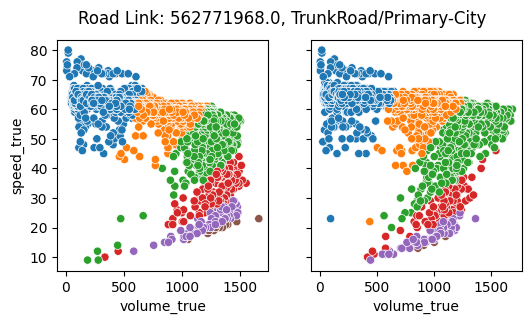

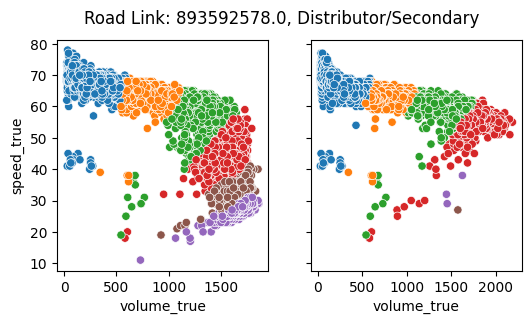

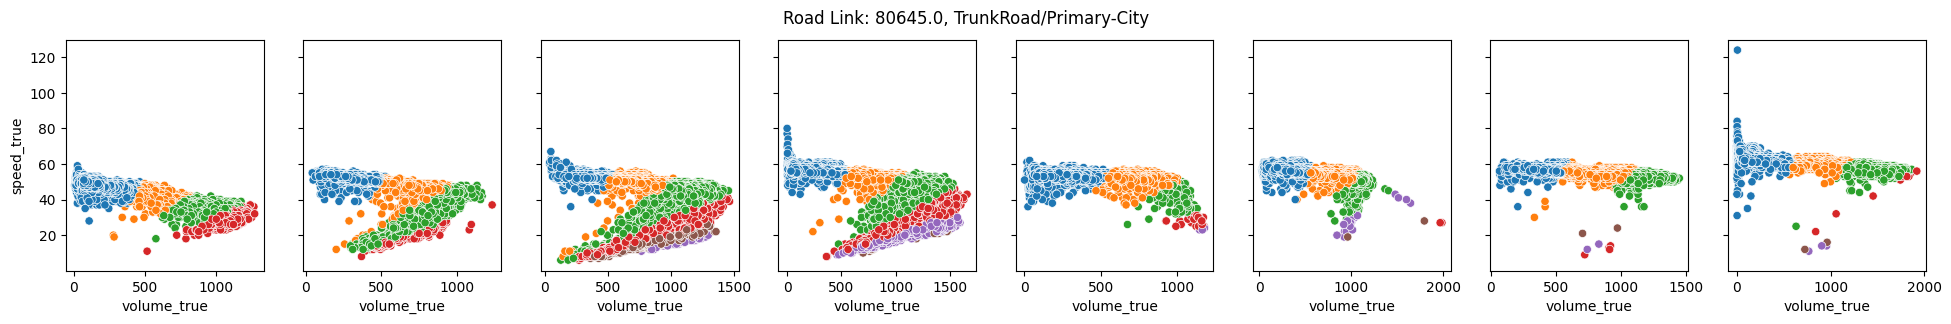

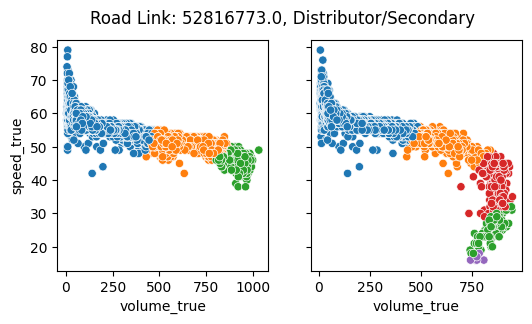

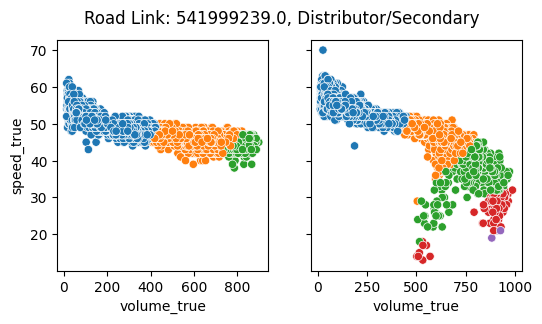

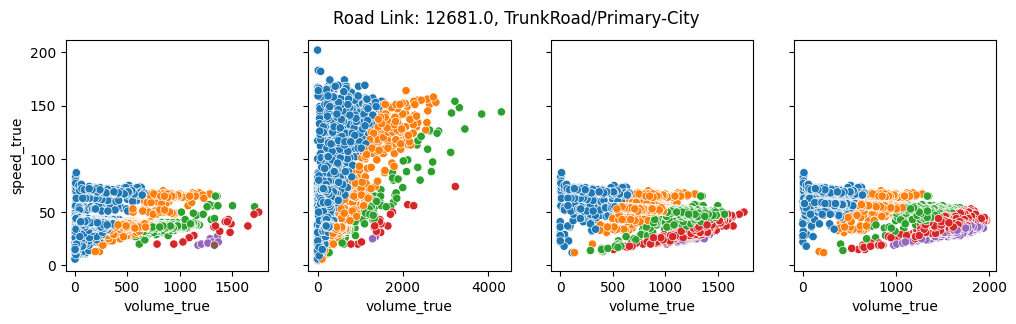

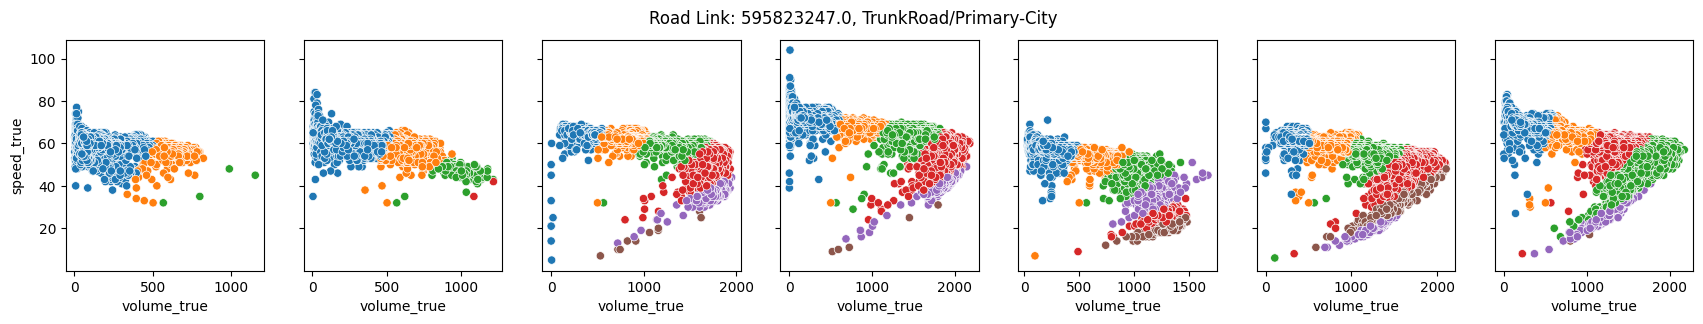

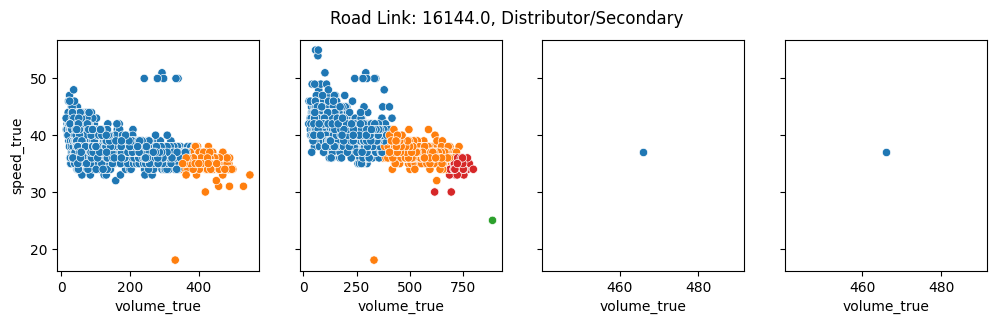

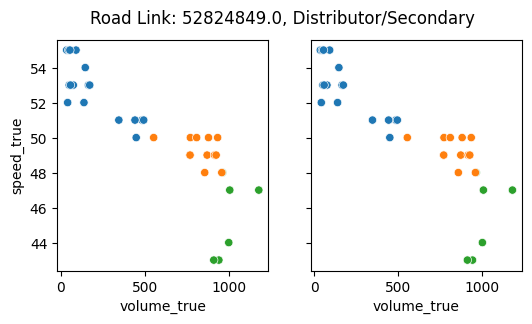

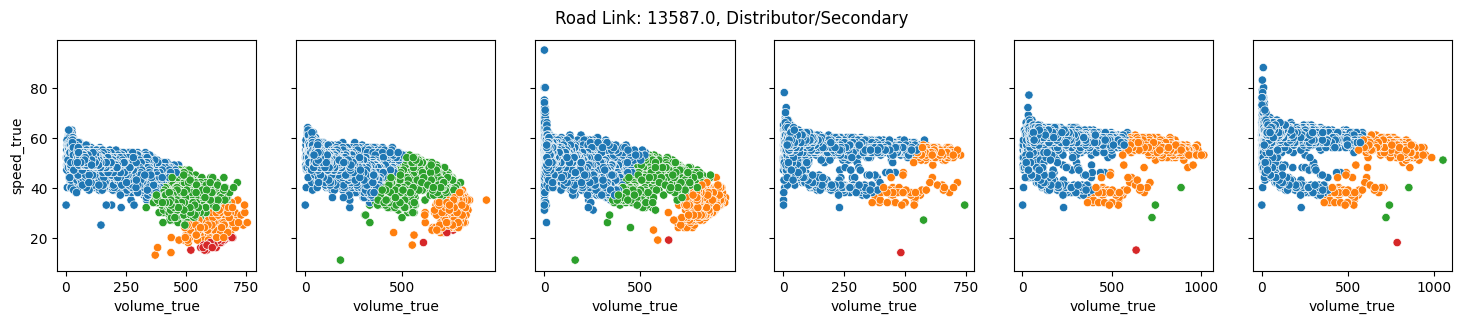

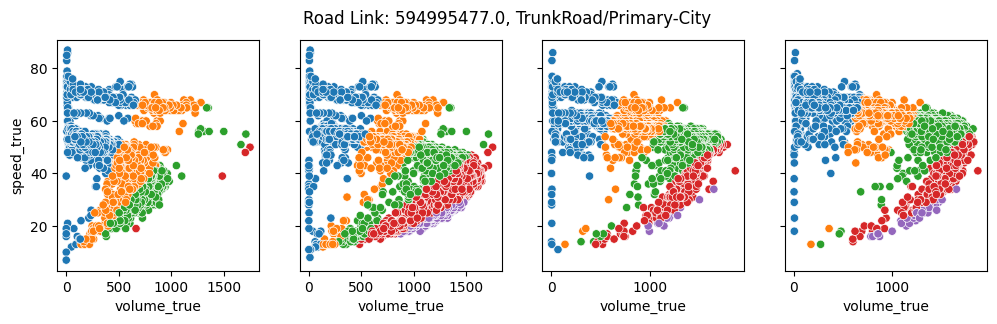

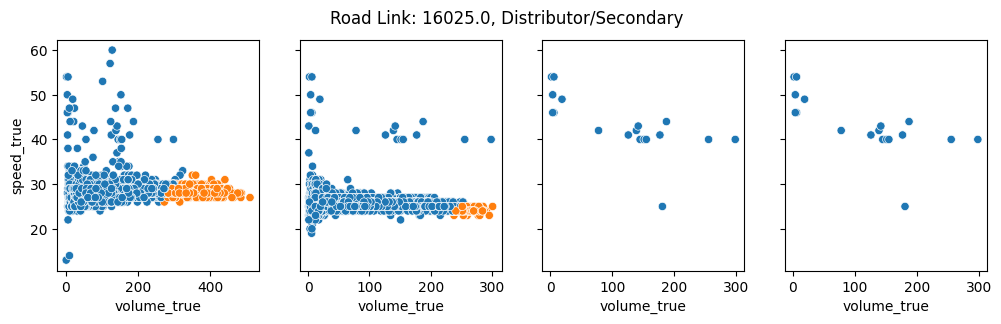

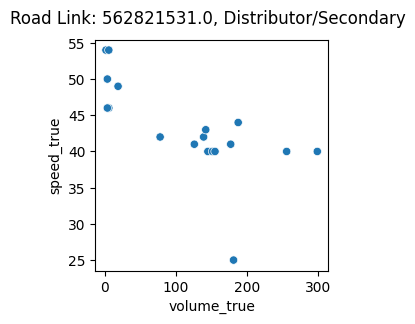

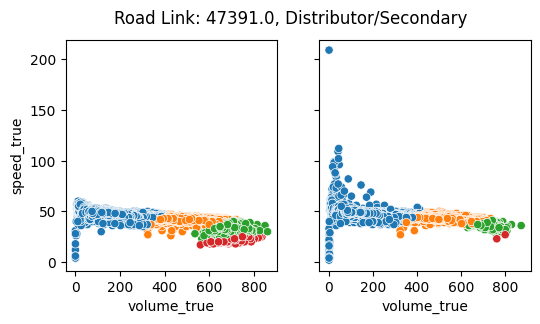

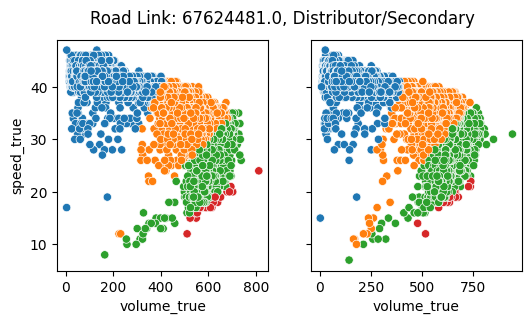

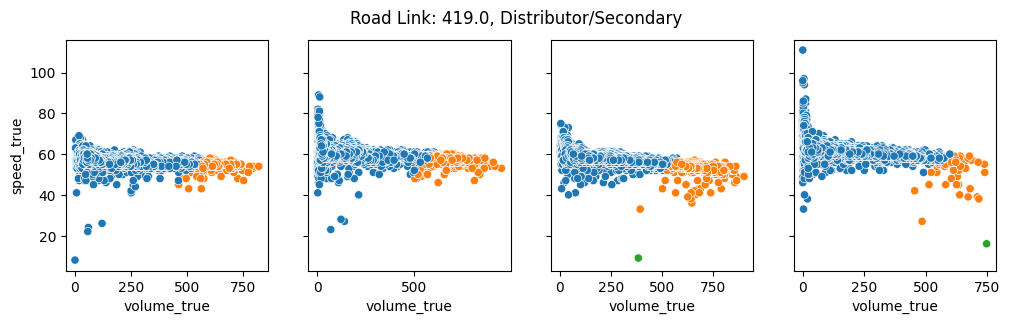

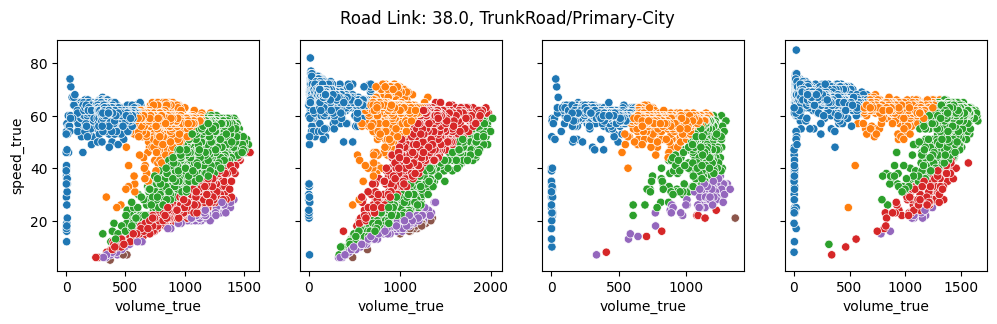

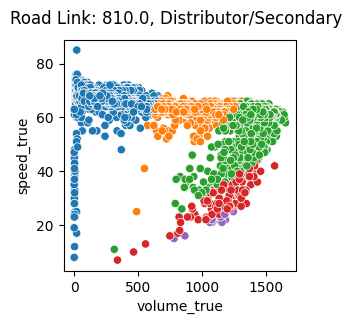

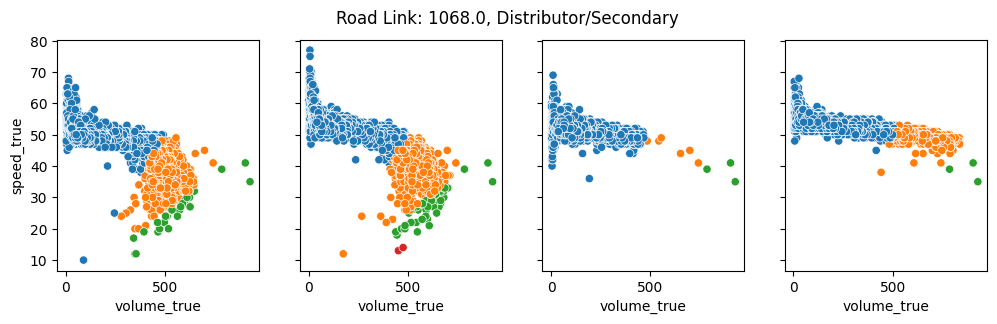

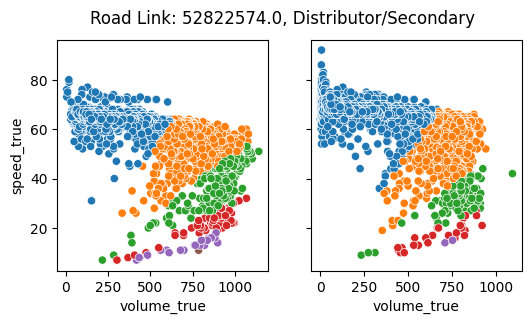

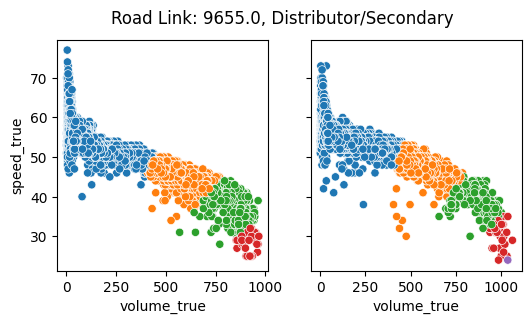

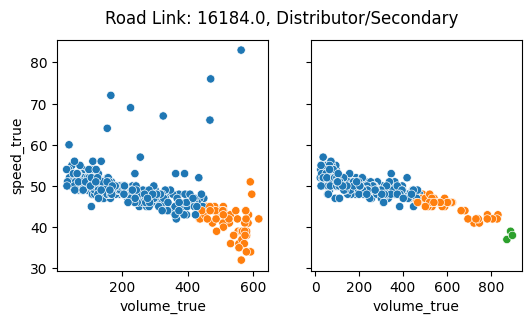

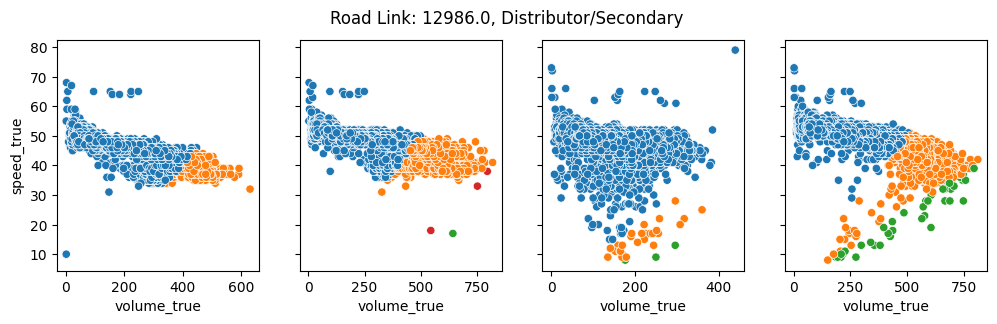

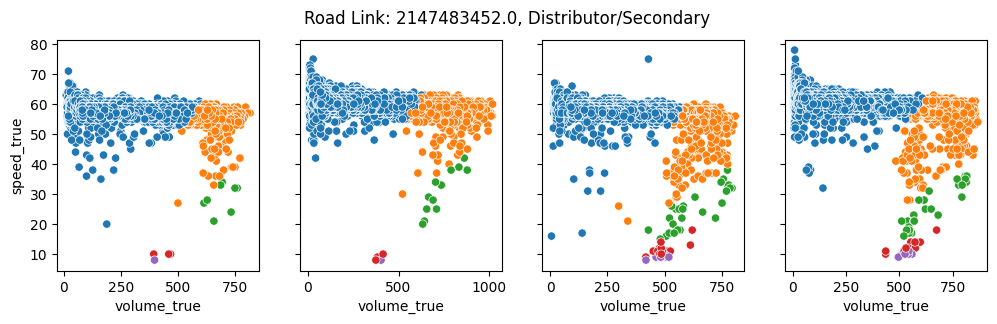

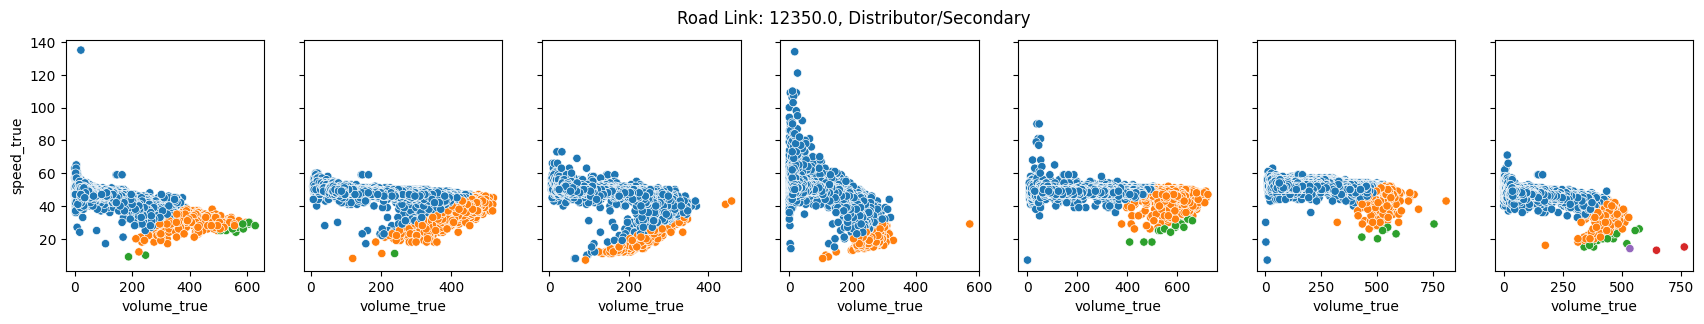

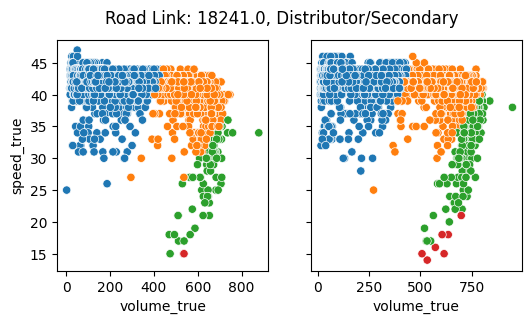

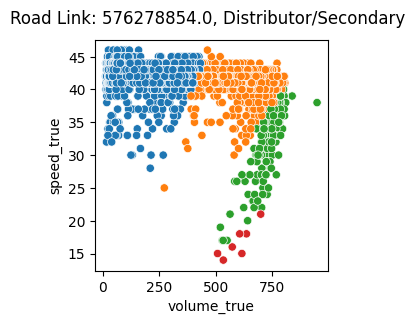

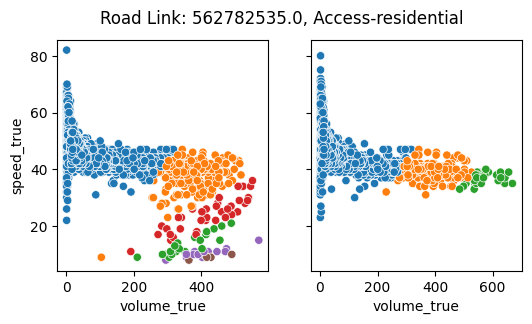

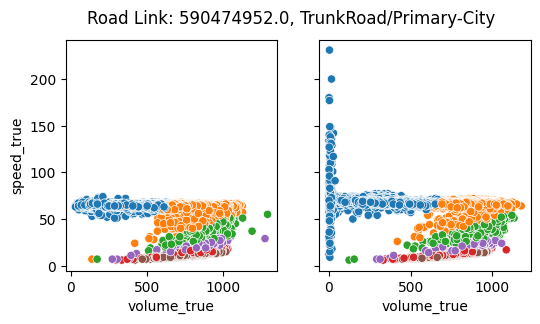

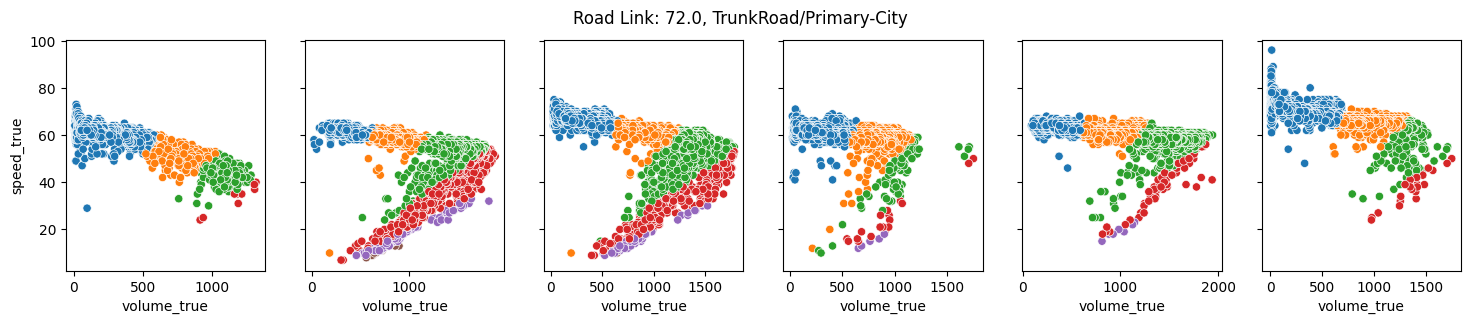

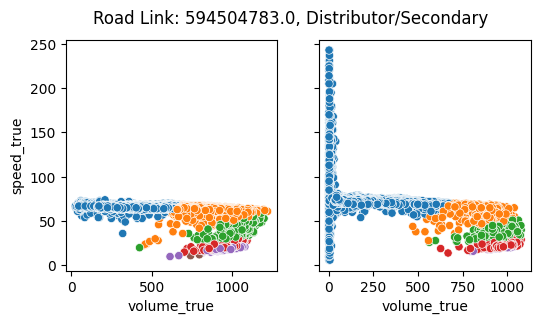

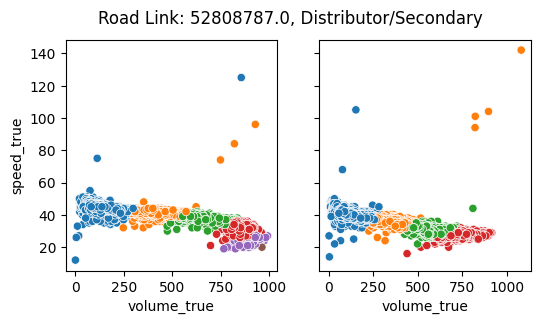

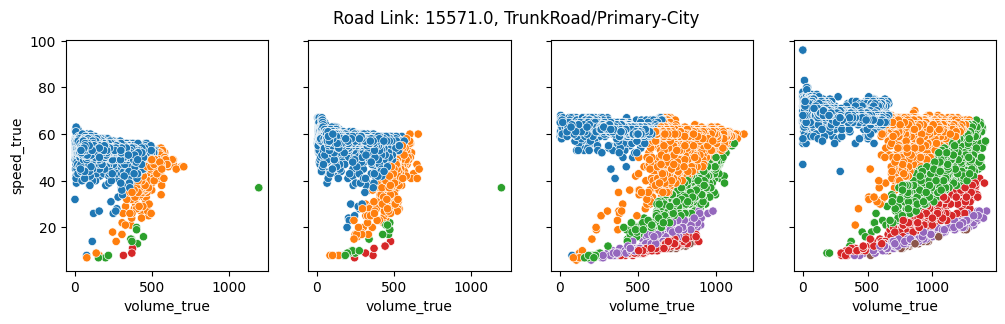

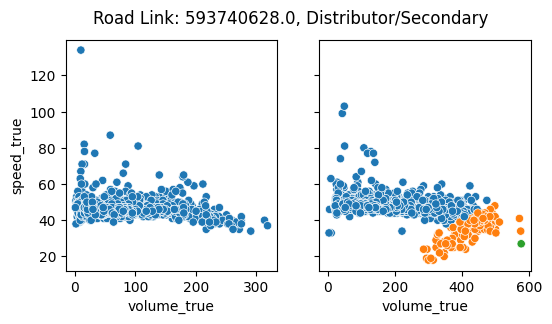

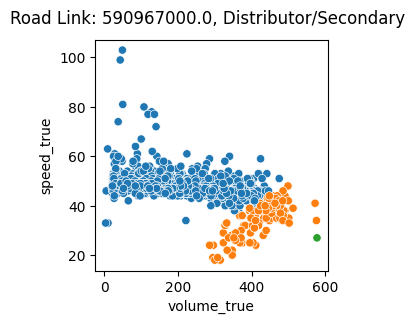

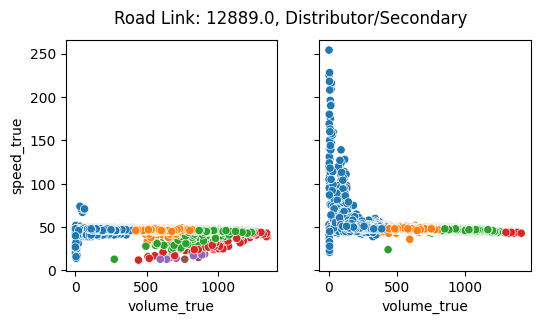

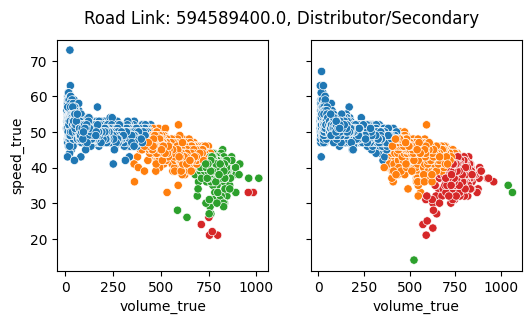

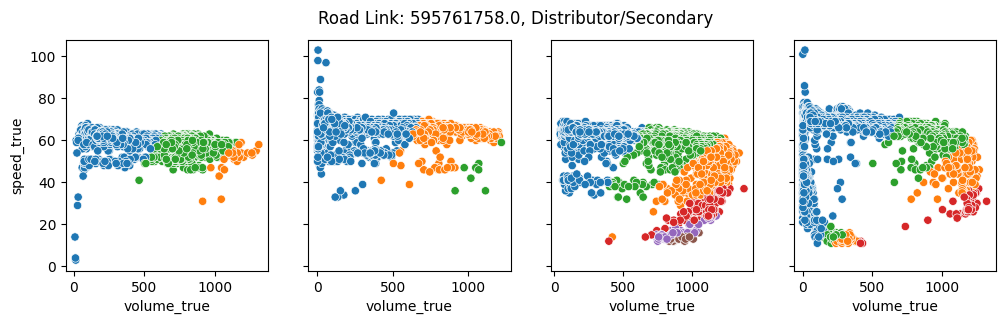

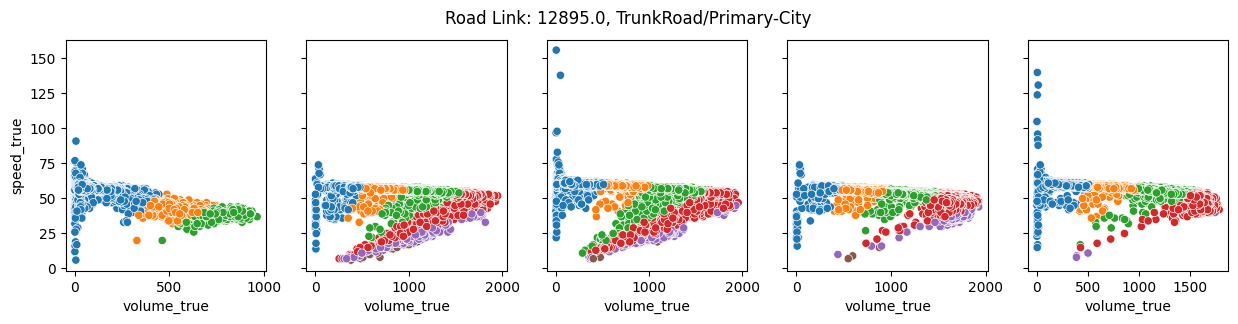

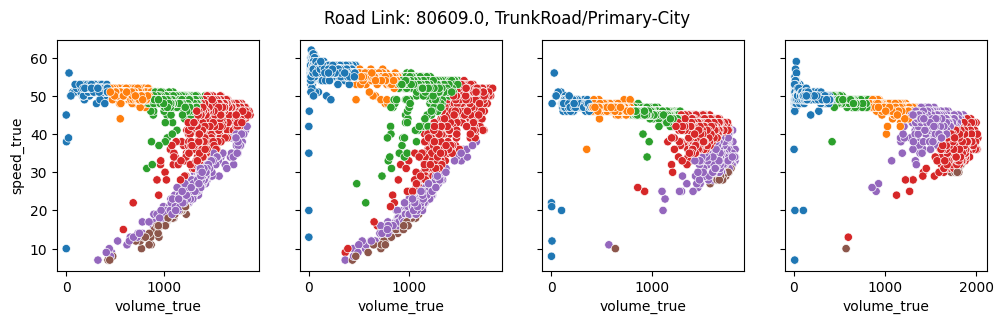

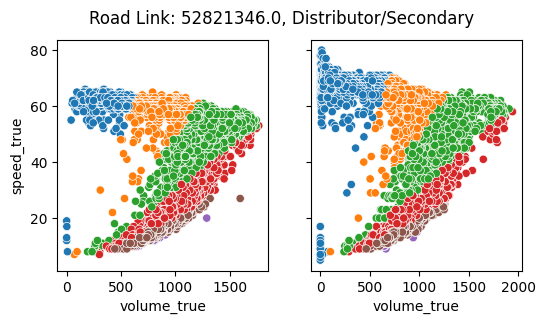

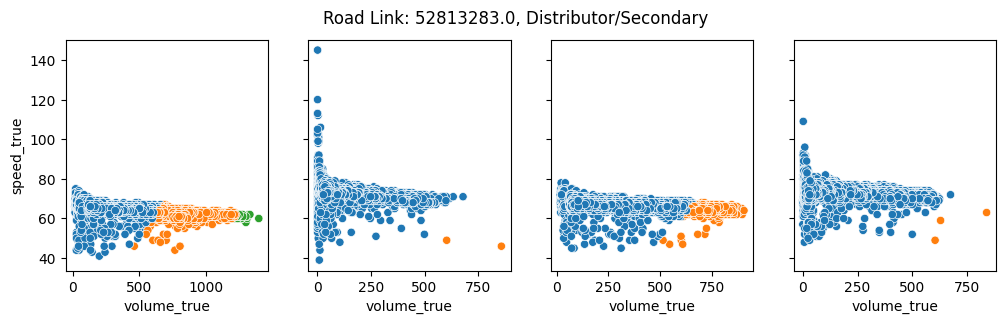

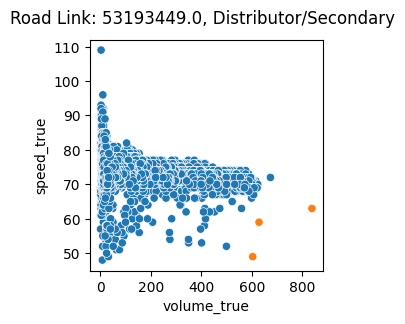

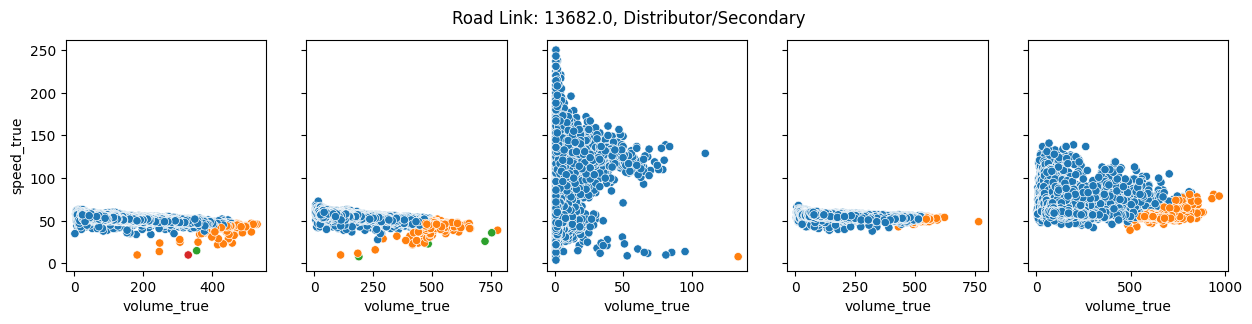

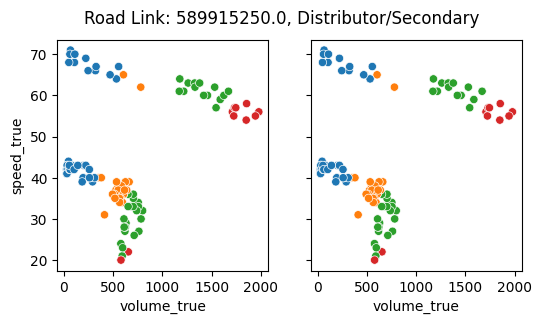

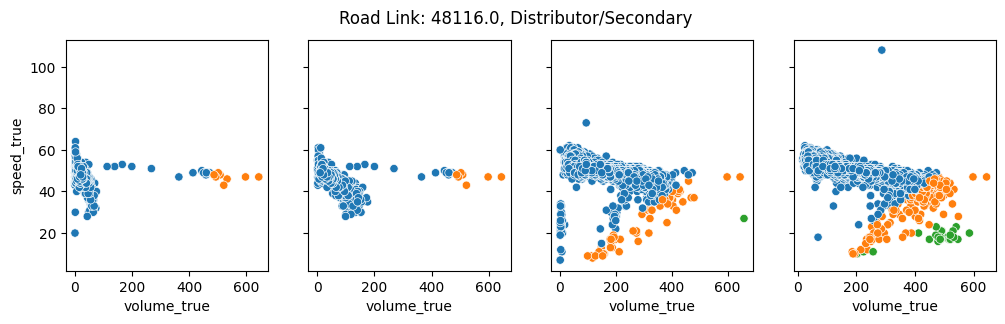

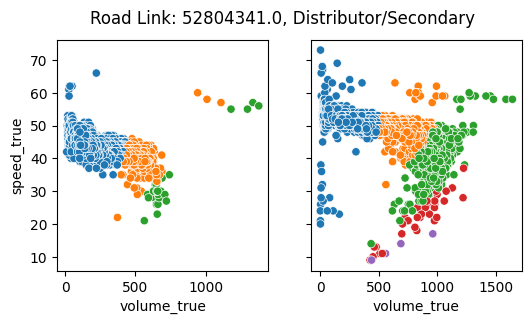

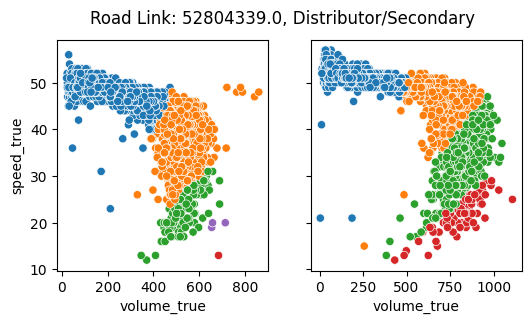

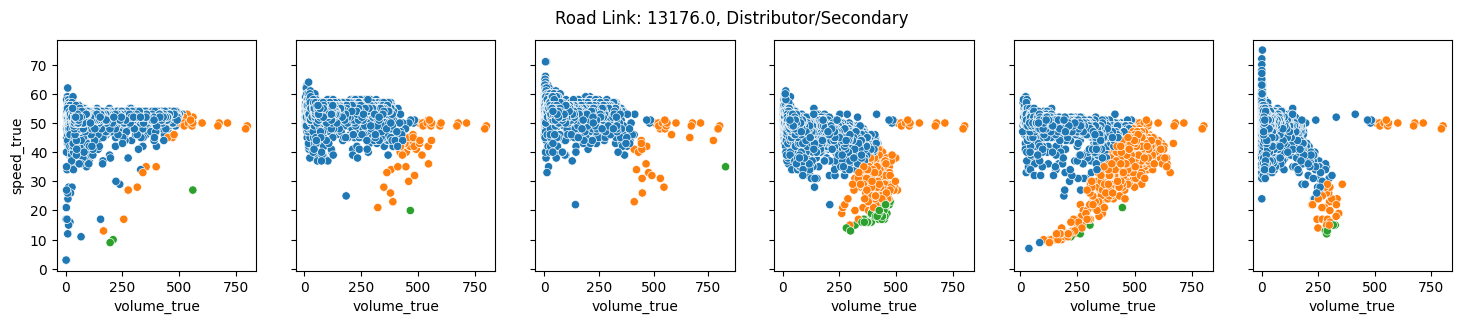

In [25]:
# Plot data from all road links

plot_df = combined_df_merged.set_index('road_link_id')

for road_link in set(plot_df.index.get_level_values(0)):
    
    df = plot_df.loc[road_link]
    road_type = df['road_type'].iloc[0]
    total_traffic_volume = df.groupby('timestamp')['volume_true'].sum()
    num_detectors = df['detector_id'].nunique()
    
    fig, ax = plt.subplots(1,num_detectors, figsize =(num_detectors*3,3), sharey = True)
    plt.suptitle(f'Road Link: {road_link}, {road_type}')
    if num_detectors > 1:
        i = 0
        for det, data in plot_df.loc[road_link].groupby('detector_id'): 
            sns.scatterplot(ax = ax[i], data = data, x = 'volume_true', y = 'speed_true', hue = 'LOS_hbs')
            ax[i].get_legend().remove()
            i+=1
    else:
        sns.scatterplot(ax = ax, data = data, x = 'volume_true', y = 'speed_true', hue = 'LOS_hbs')
        ax.get_legend().remove()

# Calculate Emission Factor Uncertainty

In [6]:
aggregated_ef = dict()
for idx, grp in combined_df_merged.groupby(['road_link_id', 'timestamp']): 
    grp['volume_share'] = grp['volume_true'] / grp['volume_true'].sum()
    combined_ef = (grp['volume_share'] * grp['ef_PC_co2(rep)']).sum()    
    aggregated_ef.update({idx:combined_ef})
    
true_emissionfactors = pd.Series(aggregated_ef).reset_index()#.loc[:]['2019-06-01':'2019-06-15'].plot()
true_emissionfactors.rename(columns = {'level_0': 'road_link_id',
                                       'level_1': 'timestamp',
                                       0: 'emission_factor'}, inplace=True)

In [7]:
road_links_with_detectors = combined_df_merged['road_link_id'].unique()
visum_reduced = visum_links[visum_links['road_link_id'].isin(road_links_with_detectors)].copy()
visum_reduced = visum_reduced.reset_index(drop=True).reset_index()

In [8]:
def process_hourly_emissions(date: str,
                            visum_dict:dict,
                            cycles_obj:TrafficCounts,
                            hbefa_obj:HbefaHotEmissions,
                            ):
    """Function to calculate daily emissions for a given date. 
    This implements the HbefaHotEmissions object and can be run as parallell processes.

    Args:
        date (str): day to be calculated
        visum_dict (dict): traffic model as dict for faster looping
        cycles_obj (TrafficCounts): object to access traffic cycles
        hbefa_obj (HbefaHotEmissions): object to access emission factors
    Returns:
        bool: true if process finished without error, false if not.
    """
    try:
        year = int(date[:4]) #convert year to integer
        
        # get scaling factors for the day
        diurnal_cycles = cycles_obj.get_hourly_scaling_factors(date=date)
        vehicle_shares = cycles_obj.get_vehicle_share(date=date).to_dict()
        daily_scaling = cycles_obj.get_daily_scaling_factors(date=date).to_dict()

        em_sum_dict = dict() # initialize result dict
        
        # loop over visum model
        for row in visum_dict:
            
            # relevant information from the visum model
            dtv_visum = row['dtv_SUM']
            hgv_corr = row['hgv_corr']
            lcv_corr = row['lcv_corr']
            scaling_road_type = row['scaling_road_type']
            
            # get vehicle shares from counting data
            hgv_share = vehicle_shares['HGV'][scaling_road_type]
            lcv_share = vehicle_shares['LCV'][scaling_road_type]
            pc_share = vehicle_shares['PC'][scaling_road_type]
            mot_share = vehicle_shares['MOT'][scaling_road_type]
            bus_share = vehicle_shares['BUS'][scaling_road_type]
            
            # calculate vehicle share correction factor
            k = (1- (hgv_corr * hgv_share)- (lcv_corr * lcv_share)) / (1 - hgv_share - lcv_share)
            
            # calculate vehicle counts and apply vehicle share correction factor
            dtv = dict()
            dtv_day = dtv_visum * daily_scaling[scaling_road_type]
            dtv.update({'HGV' : (dtv_day * hgv_share * hgv_corr)})
            dtv.update({'LCV' : (dtv_day * lcv_share * lcv_corr)})
            dtv.update({'PC' : (dtv_day * pc_share * k)})
            dtv.update({'MOT' : (dtv_day * mot_share * k)})
            dtv.update({'BUS' : (dtv_day * bus_share * k)})
            
            # calculate emissions on the respective road link
            em = hbefa_obj.calculate_emissions_hourly(dtv_vehicle = dtv,
                                                     diurnal_cycle_vehicle = diurnal_cycles,
                                                     road_type = row['road_type'], 
                                                     hbefa_gradient = row['hbefa_gradient'], 
                                                     hbefa_speed = row['hbefa_speed'],
                                                     hour_capacity = row['hour_capacity'], 
                                                     year = year)
            
            em_sum_dict.update({row['index']:em}) # add emmissions to emission dict
        return em_sum_dict
    except:
        return False

In [9]:
datetime_index = pd.date_range(start='2019-01-01', end= '2019-12-31', freq = 'd')
final_emissions = list()

for day in datetime_index: 
    out_dict = process_hourly_emissions(day.strftime('%Y-%m-%d'),
                                        visum_reduced.to_dict('records'),
                                        cycles,
                                        hbefa)
    
    df_temp = pd.DataFrame()
    for road_link_index, item in out_dict.items():
        
        data = pd.DataFrame(pd.Series(item).reset_index())
        data.rename(columns = {'level_0':'vehicle_class',
                               'level_1':'component',
                               'level_2':'hour', 
                               0:'emission'},
                    inplace = True)
        data['date'] = day
        data['road_link_index'] = road_link_index
        df_temp = pd.concat([df_temp, data], axis = 0)
    final_emissions.append(df_temp)
    print(f'finished {day}')

finished 2019-01-01 00:00:00
finished 2019-01-02 00:00:00
finished 2019-01-03 00:00:00
finished 2019-01-04 00:00:00
finished 2019-01-05 00:00:00
finished 2019-01-06 00:00:00
finished 2019-01-07 00:00:00
finished 2019-01-08 00:00:00
finished 2019-01-09 00:00:00
finished 2019-01-10 00:00:00
finished 2019-01-11 00:00:00
finished 2019-01-12 00:00:00
finished 2019-01-13 00:00:00
finished 2019-01-14 00:00:00
finished 2019-01-15 00:00:00
finished 2019-01-16 00:00:00
finished 2019-01-17 00:00:00
finished 2019-01-18 00:00:00
finished 2019-01-19 00:00:00
finished 2019-01-20 00:00:00
finished 2019-01-21 00:00:00
finished 2019-01-22 00:00:00
finished 2019-01-23 00:00:00
finished 2019-01-24 00:00:00
finished 2019-01-25 00:00:00
finished 2019-01-26 00:00:00
finished 2019-01-27 00:00:00
finished 2019-01-28 00:00:00
finished 2019-01-29 00:00:00
finished 2019-01-30 00:00:00
finished 2019-01-31 00:00:00
finished 2019-02-01 00:00:00
finished 2019-02-02 00:00:00
finished 2019-02-03 00:00:00
finished 2019-

In [10]:
df = pd.concat(final_emissions)

In [11]:
df_test = df[(df['vehicle_class']=='PC') & 
   (df['component'] == 'CO2(rep)')].copy()

df_test['datetime'] = df_test.apply(lambda row: pd.Timestamp.combine(row['date'], time(row['hour'])), axis = 1)
df_test['road_link_id'] = df_test['road_link_index'].map(visum_reduced['road_link_id'].to_dict())


<Axes: xlabel='timestamp'>

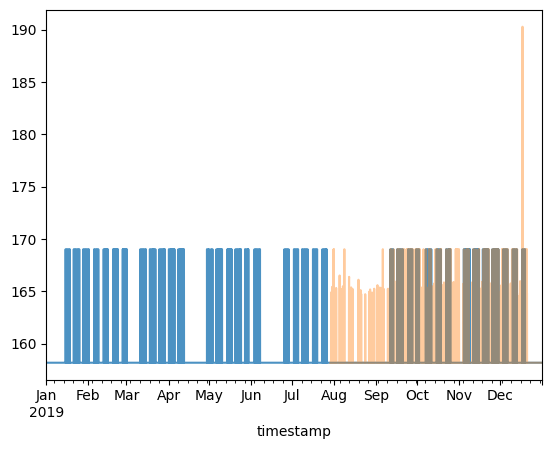

In [33]:
rl = 52804339

te = true_emissionfactors[true_emissionfactors['road_link_id']==rl].set_index('timestamp')
me = df_test[df_test['road_link_id']==rl].groupby('datetime')['emission'].mean()

plt.figure()
me.plot(alpha = 0.8)

te['emission_factor'].plot(alpha = 0.4)

In [67]:
visum_reduced[visum_reduced['hbefa_gradient']=='0%']['road_link_id'].unique()

array([      1068,       9655,      12350,      12889,      12895,
            12986,      13587,      13682,      15571,      16025,
            16144,      16184,      48116,      80609,      80645,
         52804339,   52804341,   52808787,   52813283,   52816773,
         52821346,   52822574,   53193449,  541999239,  562771968,
        562782535,  576278854,  589915250,  590474952,  593740628,
        594504783,  594589400,  594995477,  595761758,  893592578,
       2147483452])

In [93]:
true_emissionfactors

road_link_id           timestamp  emission_factor
0       3.800000e+01 2019-01-02 23:00:00       142.387375
1       3.800000e+01 2019-01-03 00:00:00       142.387375
2       3.800000e+01 2019-01-03 01:00:00       142.387375
3       3.800000e+01 2019-01-03 02:00:00       142.387375
4       3.800000e+01 2019-01-03 03:00:00       142.387375
...              ...                 ...              ...
319088  2.147483e+09 2019-12-31 19:00:00       158.182510
319089  2.147483e+09 2019-12-31 20:00:00       158.182510
319090  2.147483e+09 2019-12-31 21:00:00       158.182510
319091  2.147483e+09 2019-12-31 22:00:00       158.182510
319092  2.147483e+09 2019-12-31 23:00:00       158.182510

[319093 rows x 3 columns]